## Data Preparation 

We use Beeline benchmark to benchmark the performance of DeepSEM.
The data preparation process are shown in below.
1. Download raw data from https://doi.org/10.5281/zenodo.3378975, which is provided by BEELINE benchmark
2. Use the preoprocess code in https://github.com/Murali-group/Beeline/blob/master/generateExpInputs.py to generate dataset.

We also provide demo data as shown in ../demo_data/GRN_inference/input 

# Run DeepSEM by using following command:
for cell type specific GRN inference task: python main.py --task non_celltype_GRN --data_file demo_data/GRN_inference/input/500_STRING_hESC/data.csv --net_file demo_data/GRN_inference/input/500_STRING_hESC/label.csv --setting new --alpha 100 --beta 1 --n_epoch 90 --save_name out


for cell type non-specific GRN inference task: python main.py --task celltype_GRN --data_file demo_data/GRN_inference/input/500_ChIP-seq_hESC/data.csv --net_file demo_data/GRN_inference/input/500_ChIP-seq_hESC/label.csv --setting new --alpha 0.1 --beta 0.01 --n_epochs 150  --save_name out

In [43]:
!python ../main.py --task non_celltype_GRN --data_file ../demo_data/GRN_inference/input/500_STRING_hESC/data.csv --net_file ../demo_data/GRN_inference/input/500_STRING_hESC/label.csv --setting new --alpha 100 --beta 1 --n_epoch 90 --save_name out
#!python ../main.py --task celltype_GRN --data_file ../demo_data/GRN_inference/input/500_ChIP-seq_hESC/data.csv --net_file ../demo_data/GRN_inference/input/500_ChIP-seq_hESC/label.csv --setting new --alpha 0.1 --beta 0.01 --n_epochs 150  --save_name out

Using inverse constraint
dir exist
epoch: 1 Ep: 222 Epr: 2.168150853140282 loss: 1.02271302541097 mse_loss: 0.7530966401100159 kl_loss: 0.13703571011622748 sparse_loss: 0.1325806894650062
epoch: 2 Ep: 267 Epr: 2.6076408909389883 loss: 1.0138637920220692 mse_loss: 0.7537549237410227 kl_loss: 0.12509717171390852 sparse_loss: 0.13501170774300894
epoch: 4 Ep: 293 Epr: 2.861568468333796 loss: 0.9634573459625244 mse_loss: 0.6226864606142044 kl_loss: 0.1974144292374452 sparse_loss: 0.1433564672867457
epoch: 5 Ep: 304 Epr: 2.9689993664623686 loss: 0.9532651752233505 mse_loss: 0.6173700739940008 kl_loss: 0.1829339601099491 sparse_loss: 0.15296114111940065
epoch: 7 Ep: 323 Epr: 3.1545618268662667 loss: 0.9223050077756246 mse_loss: 0.5767848988374075 kl_loss: 0.18400715167323747 sparse_loss: 0.1615129572649797
epoch: 8 Ep: 352 Epr: 3.4377887401143217 loss: 0.9148564438025156 mse_loss: 0.5697054167588552 kl_loss: 0.17542136708895364 sparse_loss: 0.16972966367999712
epoch: 10 Ep: 349 Epr: 3.4084894

# Calculate EPR values

In [44]:
import pandas as pd
#col1 = "Gene1"
#col2 = "Gene2"
col1 = "TF"
col2 = "Target"
output = pd.read_csv("out/GRN_inference_result.tsv",sep='\t')
output['EdgeWeight'] = abs(output['EdgeWeight'])
output = output.sort_values('EdgeWeight',ascending=False)
label = pd.read_csv('../demo_data/GRN_inference/input/500_STRING_hESC/label.csv')
#label = pd.read_csv("../demo_data/GRN_inference/input/500_ChIP-seq_hESC/label.csv")
TFs = set(label['Gene1'])
Genes = set(label['Gene1'])| set(label['Gene2'])
output = output[output[col1].apply(lambda x: x in TFs)]
output = output[output[col2].apply(lambda x: x in Genes)]
label_set = set(label['Gene1']+'|'+label['Gene2'])
output = output.iloc[:len(label_set)]
len(set(output[col1]+'|'+output[col2]) & label_set) / (len(label_set)**2/(len(TFs)*len(Genes)-len(TFs)))


3.867512332628612

# Calculate AUPR ratio values

In [45]:
from sklearn.metrics import average_precision_score, precision_recall_curve
import numpy as np
import pandas as pd
output = pd.read_csv("out/GRN_inference_result.tsv",sep='\t')
output['EdgeWeight'] = abs(output['EdgeWeight'])
output = output.sort_values('EdgeWeight',ascending=False)
label = pd.read_csv('../demo_data/GRN_inference/input/500_STRING_hESC/label.csv')
#label = pd.read_csv("../demo_data/GRN_inference/input/500_ChIP-seq_hESC/label.csv")
TFs = set(label['Gene1'])
Genes = set(label['Gene1'])| set(label['Gene2'])
output = output[output[col1].apply(lambda x: x in TFs)]
output = output[output[col2].apply(lambda x: x in Genes)]
label_set = set(label['Gene1']+'|'+label['Gene2'])
preds,labels,randoms = [] ,[],[]
res_d = {}
l = []
p= []
for item in (output.to_dict('records')):
        res_d[item[col1] + '|' + item[col2]] = item['EdgeWeight']
for item in (set(label['Gene1'])):
        for item2 in  set(label['Gene1'])| set(label['Gene2']):
            if item+ '|' + item2 in label_set:
                l.append(1)
            else:
                l.append(0)
            if item + '|' + item2 in res_d:
                p.append(res_d[item + '|' + item2])
            else:
                p.append(-1)
                
print("AUPRC = ", average_precision_score(l,p))
print(average_precision_score(l,p)/np.mean(l))
precision, recall, thresholds = precision_recall_curve(l, p)

AUPRC =  0.0469393325430154
1.9553203615657655


Text(0, 0.5, 'precision')

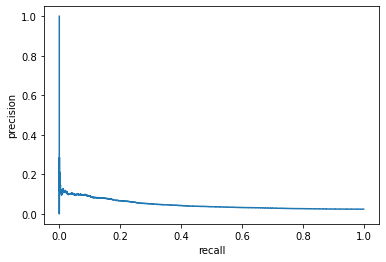

In [46]:
import matplotlib.pyplot as plt
plt.plot(recall, precision)
plt.xlabel("recall")
plt.ylabel("precision")

# Ensemble DeepSEM result

In [52]:
res = []
for i in range(10):
    res.append(pd.read_csv('../../scGRN/Upload/GRN_inference_benchmark/cross_validation/500_STRING_hESC/rep_i.csv',sep='\t'))
res = pd.concat(res)
res['EdgeWeight'] = abs(res['EdgeWeight'])
res.groupby(['Gene1','Gene2']).mean()

FileNotFoundError: [Errno 2] File ../../scGRN/Upload/GRN_inference_benchmark/cross_validation/500_STRING_hESC/rep_i.csv does not exist: '../../scGRN/Upload/GRN_inference_benchmark/cross_validation/500_STRING_hESC/rep_i.csv'